This is the notebook for determining the overhead added by parameter control.

It is divided into the main paragraphs:

- Prior Predictive Check
- Model specification and execution
- Data analysis

# Prior Predictive Check

Sampling: [a_bar, a_offset, b_offset, g_offset, sigma_a, sigma_b, sigma_g, theta]


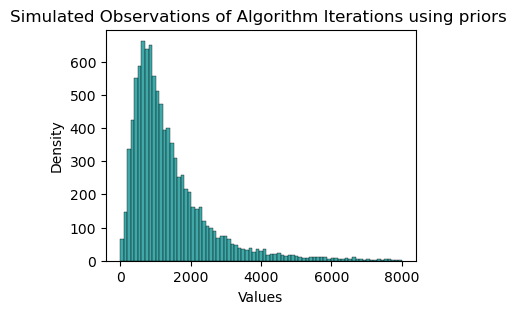

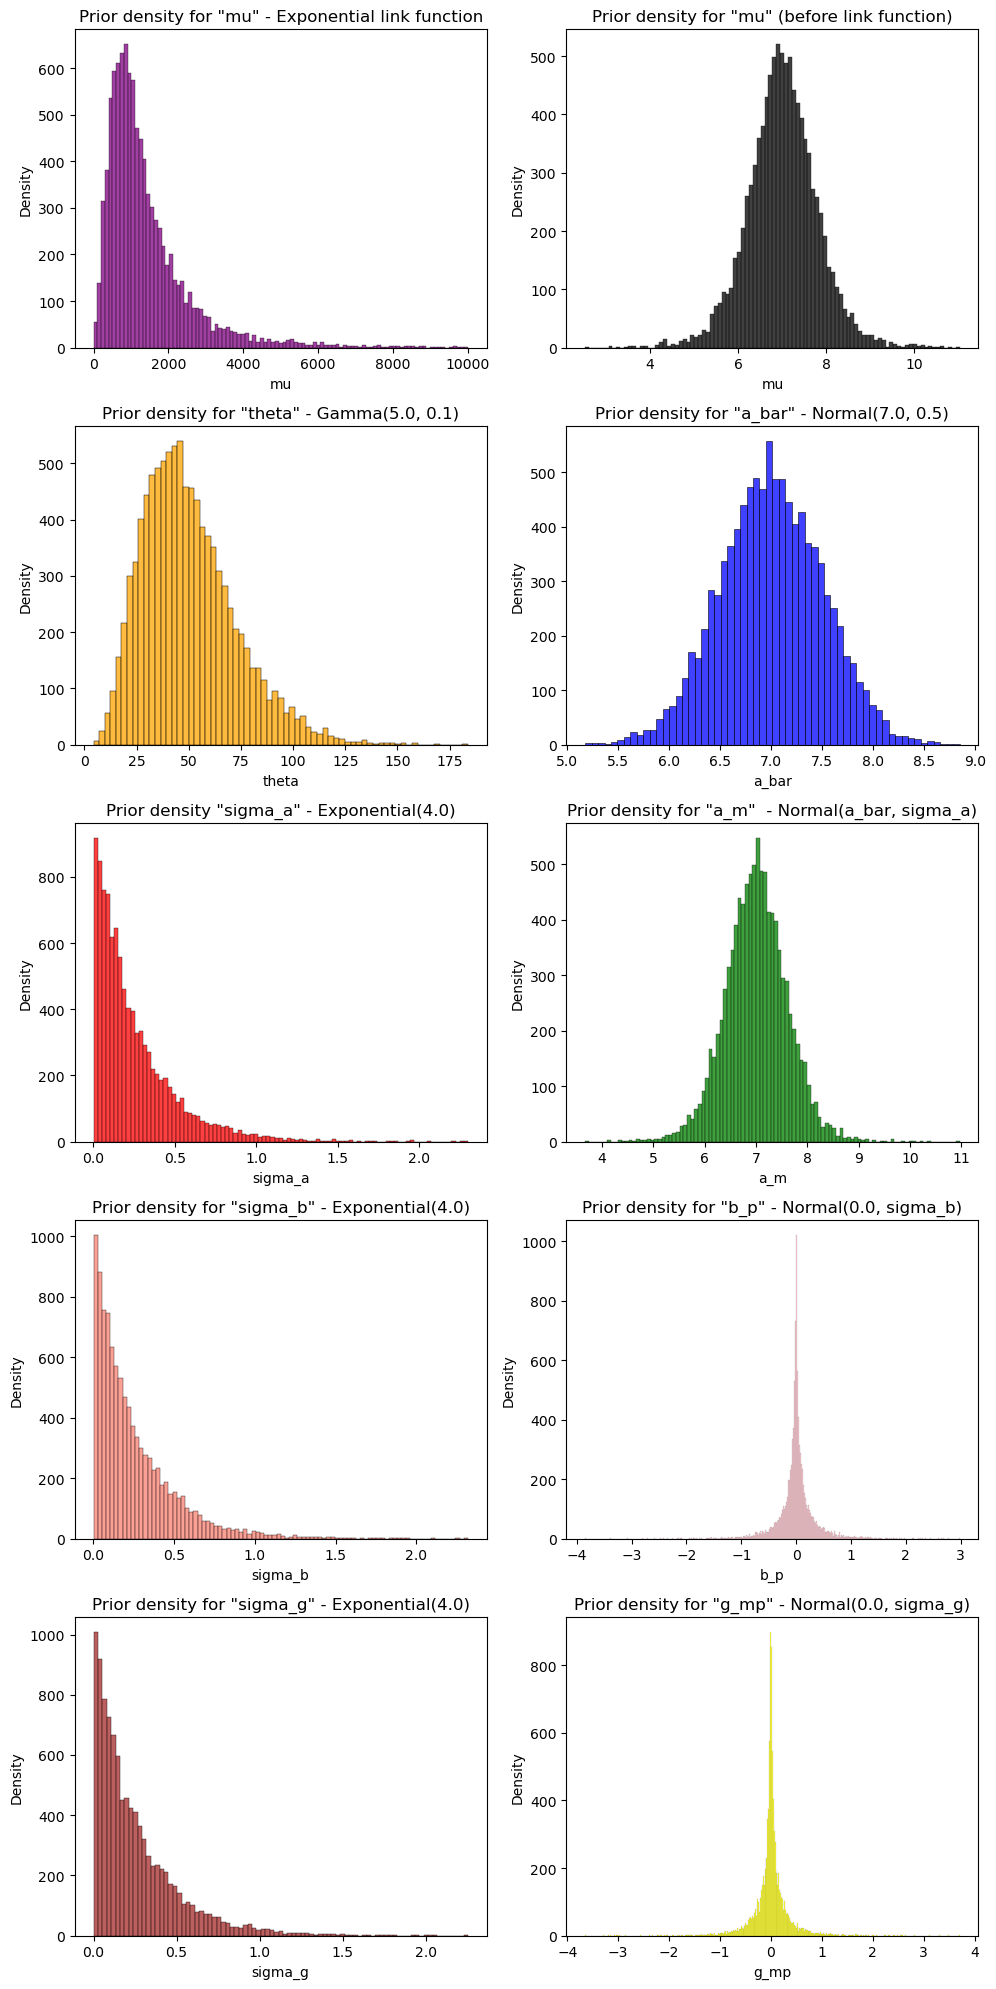

In [18]:
import pymc as pm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from ipywidgets import interact, FloatSlider
from utils.prior_check_helper import HistogramPlot, plot_histograms

def perform_prior_check(s_a, s_b, s_g, a_bar_mu, a_bar_sigma):
    with pm.Model():
        # Global Intercept for modules
        a_bar = pm.Normal('a_bar', mu=a_bar_mu, sigma=a_bar_sigma)
        
        # Standard Deviations for Module, Parameter and Interaction effects
        sigma_a = pm.Exponential('sigma_a', s_a)
        sigma_b = pm.Exponential('sigma_b', s_b)
        sigma_g = pm.Exponential('sigma_g', s_g)
        
        # Modules, Parameters and Interactions effects
        # With non-centered parameterizations (helps with divergences) 
        a_offset = pm.Normal('a_offset', mu=0, sigma=1)
        a_m = pm.Deterministic('a_m', a_bar + sigma_a * a_offset)

        b_offset = pm.Normal('b_offset', mu=0, sigma=1)
        b_p = pm.Deterministic('b_p', sigma_b * b_offset)

        g_offset = pm.Normal('g_offset', mu=0, sigma=1)
        g_mp = pm.Deterministic('g_mp', sigma_g * g_offset)


        # Link function (exp), from ln to exp
        pm.Deterministic('mu_before', a_m + b_p + g_mp)
        pm.Deterministic('mu', pm.math.exp(a_m + b_p + g_mp))
        
        # Gamma distriubtion for theta (dispersion/spread) 
        pm.Gamma('theta', alpha=5.0, beta=0.1)
        
        # Sample priors from the model
        idata = pm.sample_prior_predictive(samples=10000)



    # Fetch and flatten priors
    prior_mu= idata.prior['mu'].values.flatten()
    prior_theta = idata.prior['theta'].values.flatten()

    # Use n and p as parameters for the negative binomial
    simulated_observations = np.random.negative_binomial(n=prior_theta, p=(prior_theta)/(prior_mu + prior_theta))
    
    # Plot histogram of observaions 
    plt.figure(figsize=(4, 3))
    observation_plot = HistogramPlot(simulated_observations,'Simulated Observations of Algorithm Iterations using Priors ', 'Values',
                                     'darkcyan', bin_range=(0,8000))
    observation_plot.plot()


    # Plot priors for the different parameters
    plots = [
        HistogramPlot(idata.prior['mu'].values.flatten(), 'Prior density for "mu" - Exponential link function', 'mu', 'purple', bin_range=(0, 10000)),
        HistogramPlot(idata.prior['mu_before'].values.flatten(), 'Prior density for "mu" (before link function)', 'mu', 'black'),
        HistogramPlot(idata.prior['theta'].values.flatten(), 'Prior density for "theta" - Gamma(5.0, 0.1)', 'theta', 'orange'),
        HistogramPlot(idata.prior['a_bar'].values.flatten(), 'Prior density for "a_bar" - Normal(7.0, 0.5)', 'a_bar', 'blue'),
        HistogramPlot(idata.prior['sigma_a'].values.flatten(), 'Prior density "sigma_a" - Exponential(4.0)', 'sigma_a', 'red'),
        HistogramPlot(idata.prior['a_m'].values.flatten(), 'Prior density for "a_m"  - Normal(a_bar, sigma_a)', 'a_m', 'green'),
        HistogramPlot(idata.prior['sigma_b'].values.flatten(), 'Prior density for "sigma_b" - Exponential(4.0)', 'sigma_b', 'salmon'),
        HistogramPlot(idata.prior['b_p'].values.flatten(), 'Prior density for "b_p" - Normal(0.0, sigma_b)', 'b_p', 'pink'),
        HistogramPlot(idata.prior['sigma_g'].values.flatten(), 'Prior density for "sigma_g" - Exponential(4.0)', 'sigma_g', 'brown'),
        HistogramPlot(idata.prior['g_mp'].values.flatten(), 'Prior density for "g_mp" - Normal(0.0, sigma_g)', 'g_mp', 'yellow')
    ]

    plot_histograms(plots, 5, 2, figsize=(10,20))

perform_prior_check(4,4,4,7,0.5)


### UNCOMMENT FOR INTERACTIVE PRIOR CHECK ###

#s_a = FloatSlider(value=4, min=0.5, max=6, step=0.1, description='Sigma_alpha (sigma_a):')
#s_b = FloatSlider(value=4, min=0.5, max=6, step=0.1, description='Sigma_beta (sigma_b):')
#s_g = FloatSlider(value=4, min=0.5, max=6, step=0.1, description='Sigma_gamma (sigma_g):')
#a_bar_mu = FloatSlider(value=7, min=0, max=10, step=0.1, description='alpha bar mu (a_bar_mu):')
#a_bar_sigma = FloatSlider(value=0.5, min=0, max=3, step=0.1, description='alpha bar sigma (a_bar_sigma):')

#interact(calc_prior_dist, s_a=s_a, s_b=s_b, s_g=s_g, a_bar_mu=a_bar_mu, a_bar_sigma=a_bar_sigma)


# Run the Model

### Data Preperation


In [3]:
import pymc as pm
import pandas as pd
from utils.design_matrix_creator import get_design_matricies

# Load data
data = pd.read_csv("../single_parameter/combined_data/statistics.csv")

# Create design matricies that contain dummy variables for each module, parameter and interaction.
observation_matrix, module_matrix, parameter_matrix, interaction_matrix = get_design_matricies(data, 'AlgorithmIterations')

Module Matrix shape: (9360, 24)
Parameter Matrix shape: (9360, 12)
Interaction Matrix shape: (9360, 288)
Observation Matrix shape: (9360, 1)


### Model Specification

In [ ]:
with pm.Model() as model:
    # # Global Intercept for Modules
    a_bar = pm.Normal('a_bar', mu=7, sigma=0.5)
    
    # Standard deviations for Module, Parameter and Interaction effects
    sigma_a = pm.Exponential('sigma_a', 4.0)
    sigma_b = pm.Exponential('sigma_b', 4.0)
    sigma_g = pm.Exponential('sigma_g', 4.0)
    
    # Modules, Parameters and Interactions effects
    # With non-centered parameterizations (helps with divergences)
    a_offset = pm.Normal('a_offset', mu=0, sigma=1, shape=24)
    a_m = pm.Deterministic('a_m', a_bar + sigma_a * a_offset)

    b_offset = pm.Normal('b_offset', mu=0, sigma=1, shape=12)
    b_p = pm.Deterministic('b_p', sigma_b * b_offset)

    g_offset = pm.Normal('g_offset', mu=0, sigma=1, shape=288)
    g_mp = pm.Deterministic('g_mp', sigma_g * g_offset)

    
    # Activate the correct module, parameter and interaction for each run
    log_a = pm.math.dot(module_matrix, a_m)
    log_b = pm.math.dot(parameter_matrix, b_p)
    log_g = pm.math.dot(interaction_matrix, g_mp)

    # Link function (exp), from ln to exp
    mu = pm.Deterministic('mu', pm.math.exp(log_a + log_b + log_g))
    
    # Negative Binomial likelihood with parameter n and p
    theta = pm.Gamma('theta', alpha=5.0, beta=0.1) # Dispersion/spread parameter
    Y_obs = pm.NegativeBinomial('Y_obs', n=theta, p=(theta)/(mu + theta), observed=observation_matrix['AlgorithmIterations'])
    
    # Sample from the model
    trace = pm.sample(5000, chains=4, return_inferencedata=True, progressbar=True, target_accept=0.95)
    log_lik = pm.compute_log_likelihood(trace)
    
print("Sampling complete!")

### Save the results

In [ ]:
import arviz as az

az.to_netcdf(trace, "overhead_model_single_parameter.nc")

# Data analysis 

### Generate summary object

In [10]:
import arviz as az
import pandas as pd
from utils.inference_data_helper import create_inference_data_from_trace, log_to_exp
pd.set_option('display.max_rows', 500)  # Increase number of rows

# Example usage
trace = az.from_netcdf("overhead_model_single_parameter.nc")
variable_list = ['a_m', 'a_bar', 'sigma_a', 'theta', 'sigma_b', 'b_p', 'sigma_g', 'g_mp']
transformations = {
    'a_m': log_to_exp,
    #'a_bar': log_to_exp,
    #'sigma_a': log_to_exp
    #'b_p': log_to_exp
}

idata = create_inference_data_from_trace(trace, variable_list, transformations)
summary = az.summary(idata, variable_list, hdi_prob=0.89)


### Replace numeric identifiers with descriptive identifiers

In [11]:
from utils.summary_table_formatting import update_table, get_replacement_list
from utils.design_matrix_creator import get_design_matricies

_, module_matrix, parameter_matrix, interaction_matrix = get_design_matricies(pd.read_csv("../single_parameter/combined_data/statistics.csv"), 'AlgorithmIterations')

module_names = get_replacement_list(module_matrix.columns)
parameter_names = get_replacement_list(parameter_matrix.columns)
interaction_names = get_replacement_list(interaction_matrix.columns)

update_table(summary, 'a_m', replacement=module_names)
update_table(summary, 'b_p', replacement=parameter_names)
update_table(summary, 'g_mp', replacement=interaction_names)

summary

Module Matrix shape: (9360, 24)
Parameter Matrix shape: (9360, 12)
Interaction Matrix shape: (9360, 288)
Observation Matrix shape: (9360, 1)


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a_m[timer],1295.201,16.536,1268.515,1321.127,0.109,0.077,23156.0,17556.0,1.0
a_m[decorators],1684.620,21.557,1650.576,1719.504,0.144,0.102,22397.0,16684.0,1.0
a_m[namedtupleutils],1419.268,18.172,1390.546,1448.593,0.118,0.084,23553.0,16791.0,1.0
a_m[packages],1510.310,19.267,1479.377,1540.682,0.129,0.091,22457.0,17790.0,1.0
a_m[cmd],1254.687,16.154,1228.876,1280.308,0.106,0.075,23124.0,18198.0,1.0
a_m[headers],2101.412,27.036,2058.076,2144.255,0.177,0.125,23348.0,18318.0,1.0
a_m[h_base],1698.189,21.700,1662.928,1732.106,0.144,0.102,22658.0,17174.0,1.0
a_m[da],619.714,8.083,606.983,632.734,0.055,0.039,21759.0,18090.0,1.0
a_m[py_base],1102.237,14.042,1079.606,1124.503,0.091,0.064,23819.0,17087.0,1.0
a_m[dict_unpacking],1001.366,12.780,980.322,1021.419,0.084,0.060,23024.0,18401.0,1.0


### Plot the prior distributions and their assosicated trace plots

array([[<Axes: title={'center': 'a_m'}>, <Axes: title={'center': 'a_m'}>],
       [<Axes: title={'center': 'b_p'}>, <Axes: title={'center': 'b_p'}>],
       [<Axes: title={'center': 'g_mp'}>,
        <Axes: title={'center': 'g_mp'}>]], dtype=object)

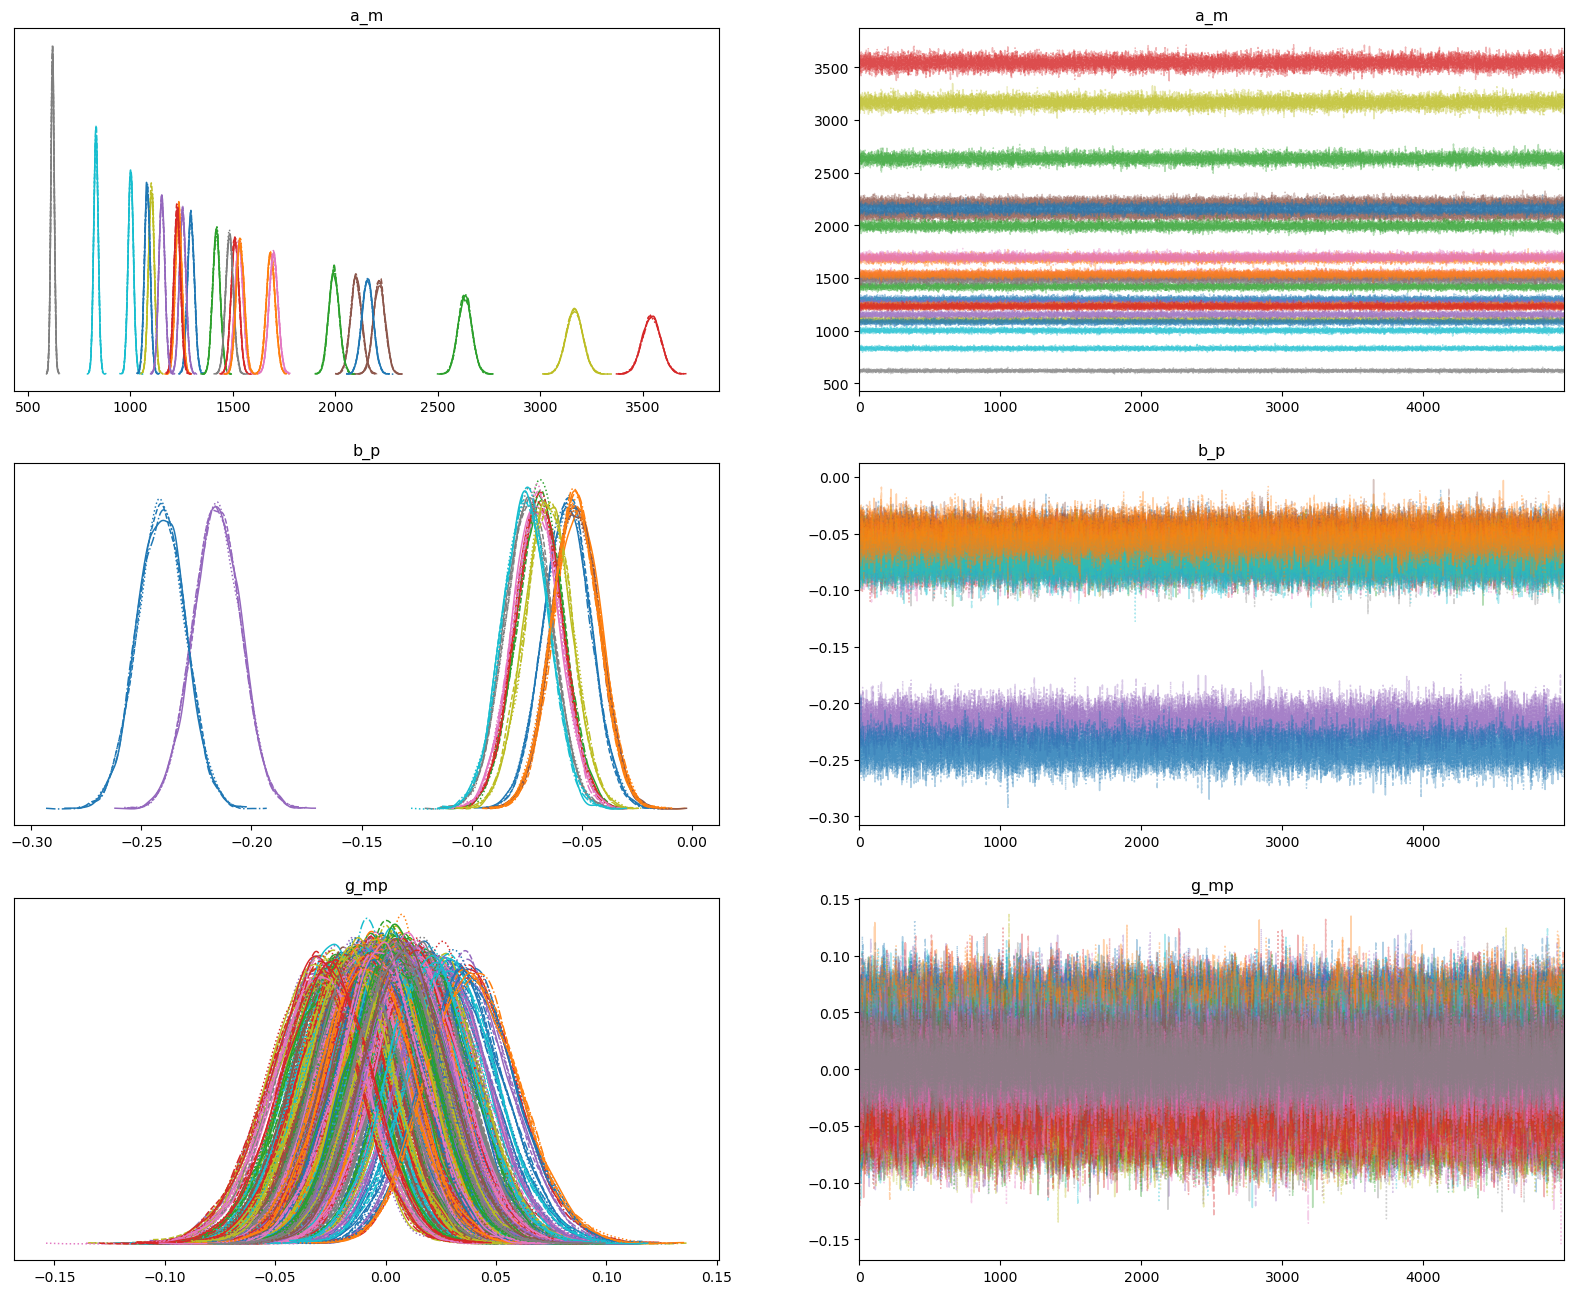

In [8]:
az.plot_trace(idata, var_names=['a_m', 'b_p', 'g_mp'], figsize=(20, 16))